<a href="https://colab.research.google.com/github/JAMES-YI/T02_CT_Image_Processing_Tutorial/blob/main/CT_reconstruction_sample_code_JYI_20210706.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code originally from Yimin Zhong at Duke University

Updated by JYI, 07/06/2021

ToDos
- get extremely familiar with the high level architecture
- get extremely familiar with each key component
- get familiar with each function
- get extremely familiar with the underlying principle
- factorization of the whole system
- evaluate the system under different setups
- evaluate the system over different datasets
- evaluate the system over different image data modalities
- algorithmic innovation and performance improvements
- under-sampling process and under-sampled image exploration
- angle optimization
- customized input
- customized layer
- customized activation functions
- customized network architecture design
- customized output
- customized evaluation metrics
- customized loss function design
- customized initialization
- customized dataset loader design
- customized reconstruction algorithm
- determine what to learn


In [ ]:
!pip install pyronn tensorflow==2.3 tensorflow_addons
"""
ToDos
- read documentations
  - pyronn
  - tensorflow 
- factorization of this file
"""

     |████████████████████████████████| 320.4MB 52kB/s 
     |████████████████████████████████| 686kB 40.8MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
     |████████████████████████████████| 460kB 50.7MB/s 
     |████████████████████████████████| 2.9MB 40.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


'\nToDos\n- read documentations\n  - pyronn\n  - tensorflow \n- factorization of this file\n'

# Step: Libraries import

In [ ]:
import sys
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Layer                                       #! tensorflow downgraded to 2.3 in order to use pyronn.
import tensorflow.keras.backend as K
import tensorflow.keras.models
from tensorflow.keras.layers import Layer, Activation, LeakyReLU, ReLU
from tensorflow.keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

tf.keras.backend.set_floatx('float32')

from pyronn.ct_reconstruction.layers.projection_2d import parallel_projection2d
from pyronn.ct_reconstruction.layers.backprojection_2d import parallel_backprojection2d
from pyronn.ct_reconstruction.geometry.geometry_parallel_2d import GeometryParallel2D
from pyronn.ct_reconstruction.helpers.filters import filters
from pyronn.ct_reconstruction.helpers.trajectories import circular_trajectory
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan

from matplotlib import pyplot as plt


Tensorflow: memory_growth is set to True


JYI
- tf.keras.backend.set_floatx: set up default data type
https://www.tensorflow.org/api_docs/python/tf/keras/backend/set_floatx
- 


# Step: Set up geometry 

In [ ]:
"""
<set_geometry_info>

@param  volume_size:            image width and height in pixel
        volume_spacing:         spacing between voxels
        detector_shape:         number of detectors for each projection
        detector_spacing:       spacing between voxels for detectors
        number_of_projections:  number of projections
        angular_range:          range of covered angles

@return geometry object 
        <pyronn.ct_reconstruction.geometry.geometry_parallel_2d.GeometryParallel2D>
"""
def set_geometry_info(volume_size=256, 
                      volume_spacing=[1,1], 
                      detector_shape=800,
                      detector_spacing=1, 
                      number_of_projections=180, 
                      angular_range= 2 * np.pi):

    volume_shape = [volume_size, volume_size]
    geometry = GeometryParallel2D(volume_shape, 
                                  volume_spacing, 
                                  detector_shape, 
                                  detector_spacing, 
                                  number_of_projections, 
                                  angular_range)

    geometry.set_trajectory(circular_trajectory.circular_trajectory_2d(geometry))

    return geometry



In [ ]:
# # JYI - Exploration of geometry object
# gmt = set_geometry_info()
# rv_index = 2

# print(f"gmt type: {type(gmt)}")
# print(f"gmt: {gmt}")
# print(f"gmt ray vector shape: {gmt.ray_vectors.shape}")
# print(f"gmt ray vector shape 1st sample: {gmt.ray_vectors[rv_index]}")
# print(f"gmt set_trajectory: {gmt.set_trajectory}")

# # JYI - Exploration of circular_trajectory_2d object
# traj = circular_trajectory.circular_trajectory_2d(gmt)
# print(f"traj shape: {traj.shape}")
# print(f"first sample in traj: {traj[rv_index]}")

gmt type: <class 'pyronn.ct_reconstruction.geometry.geometry_parallel_2d.GeometryParallel2D'>
gmt: <pyronn.ct_reconstruction.geometry.geometry_parallel_2d.GeometryParallel2D object at 0x7fa78b68e7d0>
gmt ray vector shape: (180, 2)
gmt ray vector shape 1st sample: [0.9975641  0.06975647]
gmt set_trajectory: <bound method GeometryParallel2D.set_trajectory of <pyronn.ct_reconstruction.geometry.geometry_parallel_2d.GeometryParallel2D object at 0x7fa78b68e7d0>>
traj shape: (180, 2)
first sample in traj: [0.99756405 0.06975647]


JYI - physical meanings
- volume_size: image width and height --> 2D image
- detector_shape: in parallel projection case with 2D image, detector shape is the number of beams associated with each angle
- detector_spacing: in parallel projection case with 2D image, detector spacing is the distance between neighboring beams associated with each angle
- circular_trajectory.circular_trajectory_2d(geometry): (1) 2D array, [number of ray vectors, 2], number of ray vectors == number of projections == number of angles; 
  (2) each ray vector is determined by orgin and a point on unit circle;
  (3) point on unit circle is determined by the angle formed by ray vector the horizontal axis [cos(theta), sin(theta)]; 
  (4) angular range is evenly divided into as many as ray vectors
- geometry.set_trajectory: only change data type
- circular_trajectory.circular_trajectory_2d(gmt) is exactly the same as gmt.ray_vectors

Documentations
- GeometryParallel2D: https://github.com/csyben/PYRO-NN/blob/master/pyronn/ct_reconstruction/geometry/geometry_parallel_2d.py
- circular_trajectory_2d: https://github.com/csyben/PYRO-NN/blob/master/pyronn/ct_reconstruction/helpers/trajectories/circular_trajectory.py
  


# Step: Projection and undersampling

In [ ]:
"""
<forward_operator>

@param  batch_images:   tf.Tensor of dimension N_batch x Width x Height (dtype=float).
        geometry:       GeometryParallel2D object.
        noise:          noise level. None if no noise added.  

@return sinogram batch images of dimension N_batch x N_Projection x N_Detector
"""
def forward_operator(batch_images, geometry, noise=None):
    sinogram = parallel_projection2d(batch_images, geometry)

    if noise:
        sinogram = sinogram + \
        np.random.normal(loc=np.mean(np.abs(sinogram)), scale=np.std(sinogram), size=sinogram.shape) * noise

    return sinogram 


In [ ]:
# # JYI - Exploration of forward operator or projection with imagenet dataset
# from tensorflow.keras.datasets import mnist

# gmt = set_geometry_info(volume_size=28)

# (train_images,train_labels), (test_images,test_labels) = mnist.load_data()
# bc_images = train_images[0:25,]

# sngm = forward_operator(batch_images=bc_images,geometry=gmt)


sngm: (25, 180, 800)
sngm type: <class 'tensorflow.python.framework.ops.EagerTensor'>
sngm range: 0.0, 5435.3046875
sngm[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
sngm[0].shape: (180, 800)


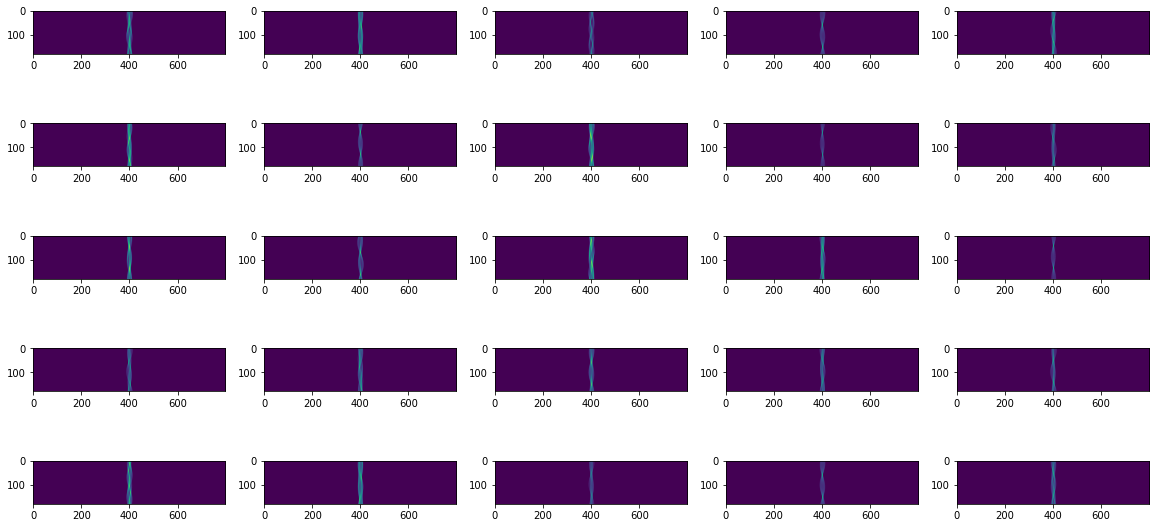

In [ ]:
# JYI - Exploration of sinograms
# print(f"sngm: {sngm.shape}") # (# of samples, # of projections, # of detectors or detector_shape) or (number, 180, 800)
# print(f"sngm type: {type(sngm)}")
# print(f"sngm range: {np.min(sngm)}, {np.max(sngm)}") # [0.0, 5435]
# print(f"sngm[0]: {sngm[0]}")
# print(f"sngm[0].shape: {sngm[0].shape}")

# plt.figure(figsize=(20,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     #plt.xticks([])
#     #plt.yticks([])
#     #plt.grid(False)
#     plt.imshow(sngm[i])
# plt.show()


JYI
- 3D RBG image? 4D RGB image?
- parallel_projection2d: https://github.com/csyben/PYRO-NN/blob/master/pyronn/ct_reconstruction/layers/projection_2d.py 
  return an object of pyronn_layers.parallel_projection2d
- np.broadcast_to: https://numpy.org/doc/stable/reference/generated/numpy.broadcast_to.html
- sinogram is the measurements or observations; will be used to reconstruct the image
- celeb_a dataset not available in tfds
- streak artifacts can appear when undersampling is performed
- undersampling: (1) less than 180 degree for projections; or (2) sparse sampling;
- sparse sampling: spacing between neighboring projections is large
- full sampling: 2~3 projections in one degree
- fully sampling in clinical cbct: 900 projections in 360 degree
- sparse sampling: 90, or 72, or 36 projections in 360 degree
- fully sampling in practice: 1 projection for one degree
- half fan
- full fan
- cbct half fan and full fan



ToDos
- explore sinogram
- https://www.tensorflow.org/datasets/overview
- tensorflow_datasets, https://www.tensorflow.org/datasets/catalog/overview
- import tensorflow_datasets as tfds
- ds = tfds.load('lsun', split='train', shuffle_files=True) # 3.06 Gb
- ds = tfds.load('arc', split='train', shuffle_files=True) # 465 Kb
- sinogram of size (180,800) for each sample of size(28,28) --> oversampling
- what about the undersampling case, e.g., sinogram of size (180,4), (7,100)?
- how sinograms are computed?


# Step: Backprojection and reconstruction

In [ ]:
"""
<backward_operator>

@param  sinogram:     tf.Tensor of dimension N_batch x N_Projection x N_Detector (dtype=float).

@return reconstruction: tf.Tensor of dimension N_batch x Width X Height (dtype=float)

@caution 

The use of tf.complex64 is non-standard (error around 1E-4). Usually fft packages use complex128 by default. 
However, the pyronn's function 'parallel_backprojection2d' demands a float type input.
"""
def backward_operator(sinogram, geometry):
    _filter   = filters.ram_lak_2D(geometry)
    _frequecy = tf.signal.fft(tf.cast(sinogram,dtype=tf.complex64))
    filtered_sinogram =  tf.math.real(tf.signal.ifft(
                tf.multiply(_frequecy,tf.cast(_filter,dtype=tf.complex64)) 
                )) 

    reconstruction = parallel_backprojection2d(filtered_sinogram, geometry)

    return reconstruction 
  


JYI
- filters.ram_lak_2D
- tf.signal.fft
- tf.cast
- tf.math.real
- tf.signal.ifft
- parallel_backprojection2d: https://github.com/csyben/PYRO-NN/blob/726b62b57d7093ff0f3e675e66d976d989eebc0a/pyronn/ct_reconstruction/layers/backprojection_2d.py
- np.alen: https://www.kite.com/python/docs/numpy.alen
- _filter
- _frequency


In [ ]:
# # JYI - Exploration of backprojection and reconsturction I
# from tensorflow.keras.datasets import mnist
# (train_images, train_labels),(_,_) = mnist.load_data()

# truth_images = train_images[0:25,]
# gmt = set_geometry_info(volume_size=28)
# sngm = forward_operator(batch_images=truth_images,geometry=gmt)
# reconst_images = backward_operator(sinogram=sngm,geometry=gmt)


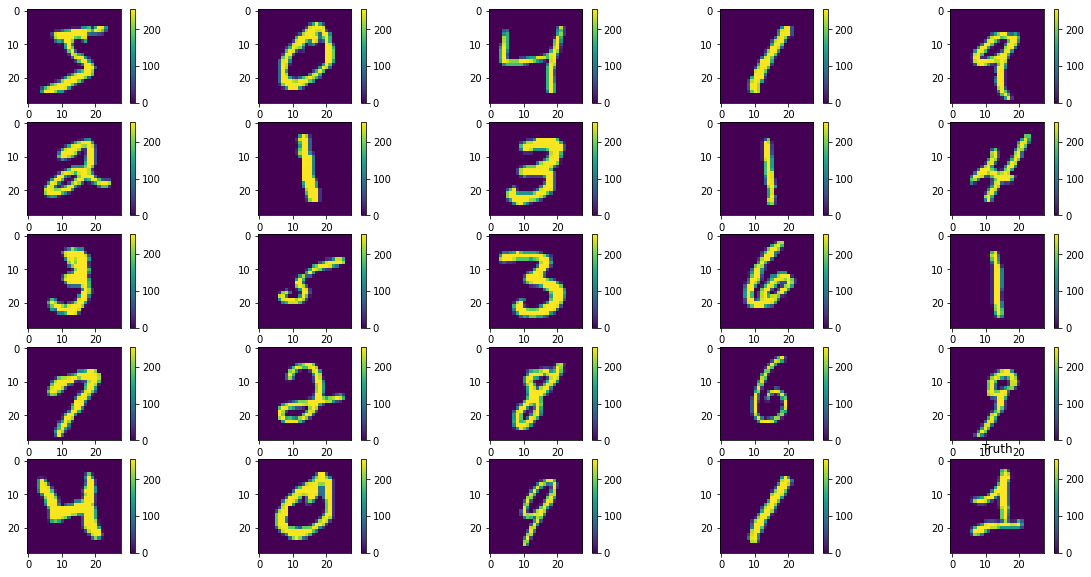

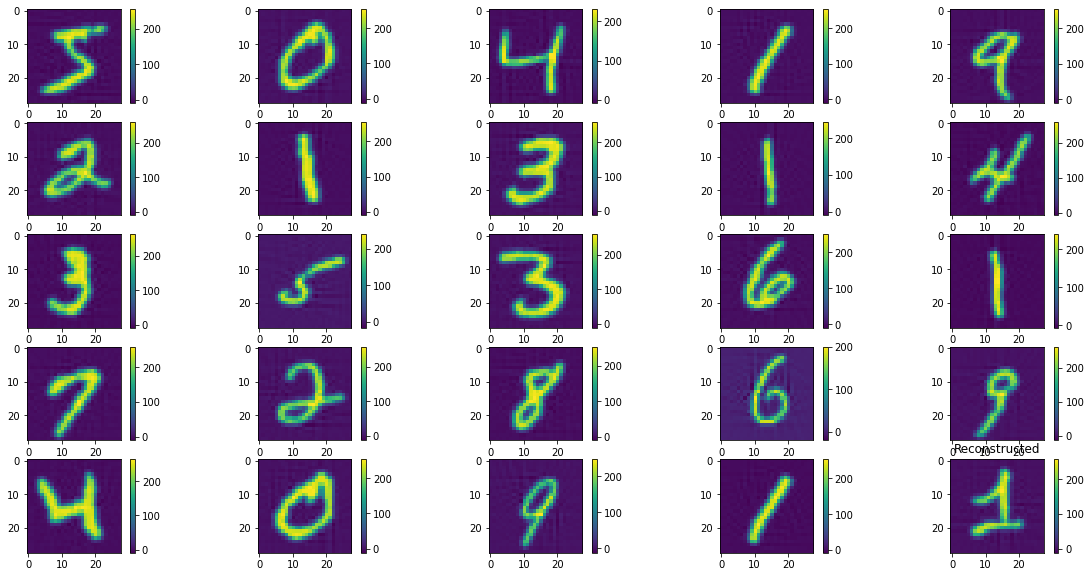

In [ ]:
# # JYI - Exploration of backprojection and reconstruction II
# plt.figure(figsize=(20,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     #plt.xticks([])
#     #plt.yticks([])
#     #plt.grid(False)
#     plt.imshow(truth_images[i])
#     plt.colorbar()

# plt.title('Truth')
# plt.show()

# plt.figure(figsize=(20,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     #plt.xticks([])
#     #plt.yticks([])
#     #plt.grid(False)
#     plt.imshow(reconst_images[i])
#     plt.colorbar()

# plt.title('Reconstructed')
# plt.show()

JYI - ToDos
- limitations of backprojection reconstruction

# Step: Customize loss for learning

In [ ]:
"""
L1 norm of w.
"""
def l1_loss(w):
    return tf.reduce_mean(tf.abs(w))


JYI - customized loss functions
- tf.math.reduce_mean, https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
- if want to use L1 loss, we should use tf.sum
- tf.math.reduce_sum, https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum
- tf.abs, https://www.tensorflow.org/api_docs/python/tf/math/abs
- size of w? 
- when the number of elements in w is too big, the regularization is too small
- 


Tips about tensorflow.Layer
- a layer encapsulates both state or weights and a transformation or call from inputs to outputs
- a layer is a class: initialize a layer, and then use it as an object
- access layer weights by layer_object.weights
- two ways for defin

ToDos
- attributes and methods associated with Layer object
  - Layer.add_weight
  - Layer.build
  - more technically strong problems
  - 



In [ ]:
################################################################################

# Layers

################################################################################
class Mask(Layer):
    def __init__(self, slope=5.0, step_slope=12.0, threshold=0.5, initializer=None, **kwargs):
        """
        @params slope:             The parameter s for f(x) = 1/ (1 + exp(-s x)), mapping (-\infty, \infty) to (0, 1). 
                step_slope:        If None, use step function for thresholding, otherwise simulate the step function 
                                      by sigmoid 1/(1+e^(-x)), this slope should be slightly larger. 
                initializer:       Uniformly distributed initialization. 
        """
        
        self.slope       = slope                                                
        #tf.Variable(slope,      dtype=tf.float32) # uncomment if it is also optimized.
        self.step_slope = step_slope
        self.threshold   = threshold                                            
        #tf.Variable(threshold,  dtype=tf.float32) 
        self.initializer = initializer

        if initializer == None:
            self.initializer = self._logit_slope_random_uniform
        else:
            self.initializer = initializer

        super(Mask, self).__init__(**kwargs)
    

    def build(self, input_shape):
        """
        @member: logit_weights \in (-\infty, \infty), trainable parameters.
        """
        
        print(f"input_shape: {input_shape}\n")
        self.logit_weights = self.add_weight(name="logit_weights", 
                                       shape=[ input_shape[-2] ],               # The dimension of mask parameters.
                                       initializer=self.initializer,
                                       trainable=True)
        
        super(Mask, self).build(input_shape)

        
    def call(self, x):
        """
        @return thresholded logit values or binary mask, e.g., value 1 means selection, and 0 means no selection.
        """
        _weights = 0*x + tf.expand_dims(self.logit_weights, axis=-1)            
        # expand the weights to full tensor.
        _logits  = tf.sigmoid(self.slope * _weights)

        self.add_loss(5  * l1_loss(_logits))                                    
        # Regularization, a larger constant is used to enforce sparsity.

        if self.step_slope is not None:
            return tf.sigmoid(self.step_slope * (_logits - self.threshold))
        else:
            return self.threshold < _logits                                     
            # tf.math.less(self.threshold, _logits) is not differentiable?


    def compute_output_shape(self, input_shape):
        return input_shape

    def _logit_slope_random_uniform(self, shape, dtype=None, eps=0.01):
        # eps could be very small, or something like eps = 1e-6
        #   the idea is how far from the tails to have your initialization.
        x = K.random_uniform(shape, dtype=dtype, minval=eps, maxval=1.0-eps)    # sampled on [0 + eps, 1 - eps]
        
        # logit with slope factor
        return - tf.math.log(1. / x - 1.) / self.slope

JYI
- no need for if-else
- threshold for determining whether an projection should be used
- difference between slope and step_slope? 
  slope is used for computing probabilities for each projection to be selected
  step_slope is used for thresholding the probabilities to be 0 or 1

JYI
- self._logit_slope_random_uniform
- inheritage from Layer
- physical meaning of mask?
- self.add_weight
- attributes of Layer object
- motivation of mask layer? 

JYI
- input_shape[-2]
- tf.expand_dims
- tf.sigmoid
- motivation for _weights = 0*x + tf.expand_dims(self.logit_weights, axis=-1)?
- Layer.add_loss
- _logits  = tf.sigmoid(self.slope * _weights), actually the probability or the chance for selecting an angle
- want as many zero probabilities as encouraged by l1_loss
- motivation for tf.sigmoid(self.step_slope * (_logits - self.threshold))?
- in self.call, the x is actually not used
- larger step_slope --> sigmoid function gets closer to step function 
  --> positive _logits - self.threshold is more likely to have probability 1
  &   negative _logits - self.threshold is more likely to have probability 0
  & probability means the chance for selecting a given projection
- _logits is actually probabilities
- motivation for self.logit_weights = self.add_weight(name="logit_weights",shape=[ input_shape[-2] ],initializer=self.initializer,trainable=True)

JYI
- from tensorflow.keras.layers import Layer 
- motivation for _logit_slope_random_uniform initializer or - tf.math.log(1. / x - 1.) / self.slope?
- K.random_uniform,
- tf.math.log, https://www.tensorflow.org/api_docs/python/tf/math/log
- tensorflow.keras.Model,
- tf.math.log, https://www.tensorflow.org/api_docs/python/tf/math/log 
- motivation for Mask class?
- how is self.logit_weights trained?
- self.logit_weights does not even interact with data


In [ ]:
# JYI - Exploration of layers
mskLayer = Mask()

print(f"mskLayer: {mskLayer}")

mskLayer: <__main__.Mask object at 0x7ff060e324d0>


# Step: Define model

Tips about tensorflow.keras.Model
- attributes and methods
- 

In [ ]:
# Define model

class simple_model(tensorflow.keras.Model):
    def __init__(self, geometry, mask_slopes=[5.0, 12.0]):
        super(simple_model, self).__init__()
        self.geometry = geometry 
        self.mask_layer = Mask(slope = mask_slopes[0], step_slope = mask_slopes[1], name="mask")

        # prepare u_net layers
        self.prepare_u_net()

    def call(self, inputs):
        """
        inputs: images 

        return: augmented images from backprojection reconstructed images via u-net
        """
        outputs = forward_operator(inputs, self.geometry)
        print(f"outputs shape before mask: {outputs.shape}")

        binary_mask = self.mask_layer(outputs)
        print(f"binary_mask: {binary_mask}")
        outputs = outputs * tf.cast(binary_mask, tf.float32) 

        outputs = backward_operator(outputs, self.geometry)

        # Add channel dimension for later u_net use.
        outputs = tf.expand_dims(outputs, axis=-1) 
        print(f"outputs shape before u-net: {outputs.shape}")

        outputs = self.u_net(outputs)
        outputs = tf.squeeze(outputs, axis=-1)

        return outputs

    def prepare_u_net(self):
        """
        - define u-net layers

        """

        # u-net hardcoded.
        features = 8 # 64 by default
        kern     = 3
        pool     = (2, 2)

        self.conv_1_1 = Conv2D(features, kern, padding="same", name="encode_conv_1_1")
        self.relu_1_1 = LeakyReLU()
        self.bn_1_1   = BatchNormalization()
        self.conv_1_2 = Conv2D(features, kern, padding="same", name="encode_conv_1_2")
        self.relu_1_2 = LeakyReLU()
        self.bn_1_2   = BatchNormalization()
        self.pool_1    = AveragePooling2D(pool)

        self.conv_2_1 = Conv2D(features * 2, kern, padding="same", name="encode_conv_2_1")
        self.relu_2_1 = LeakyReLU()
        self.bn_2_1   = BatchNormalization()
        self.conv_2_2 = Conv2D(features * 2, kern, padding="same", name="encode_conv_2_2")
        self.relu_2_2 = LeakyReLU()
        self.bn_2_2   = BatchNormalization()
        self.pool_2    = AveragePooling2D(pool)

        self.conv_3_1 = Conv2D(features * 4, kern, padding="same", name="encode_conv_3_1")
        self.relu_3_1 = LeakyReLU()
        self.bn_3_1   = BatchNormalization()
        self.conv_3_2 = Conv2D(features * 4, kern, padding="same", name="encode_conv_3_2")
        self.relu_3_2 = LeakyReLU()
        self.bn_3_2   = BatchNormalization()
        self.pool_3    = AveragePooling2D(pool)

        self.conv_4_1 = Conv2D(features * 8, kern, padding="same", name="encode_conv_4_1")
        self.relu_4_1 = LeakyReLU()
        self.bn_4_1   = BatchNormalization()
        self.conv_4_2 = Conv2D(features * 8, kern, padding="same", name="encode_conv_4_2")
        self.relu_4_2 = LeakyReLU()
        self.bn_4_2   = BatchNormalization()
        self.pool_4    = AveragePooling2D(pool)

        self.conv_5_1 = Conv2D(features * 16, kern, padding="same", name="encode_conv_5_1")
        self.relu_5_1 = LeakyReLU()
        self.bn_5_1   = BatchNormalization()
        self.conv_5_2 = Conv2D(features * 16, kern, padding="same", name="encode_conv_5_2") # (128,32,32)
        self.relu_5_2 = LeakyReLU()
        self.bn_5_2   = BatchNormalization()

        self.sub_1     = UpSampling2D(pool) # shape
        self.concat_1  = Concatenate(axis=-1)
        self.conv_6_1 = Conv2D(features * 8, kern, padding="same", name="decode_conv_6_1")
        self.relu_6_1 = LeakyReLU()
        self.bn_6_1   = BatchNormalization()
        self.conv_6_2 = Conv2D(features * 8, kern, padding="same", name="decode_conv_6_2")
        self.relu_6_2 = LeakyReLU()
        self.bn_6_2   = BatchNormalization()

        self.sub_2     = UpSampling2D(pool)
        self.concat_2  = Concatenate(axis=-1)
        self.conv_7_1 = Conv2D(features * 4, kern, padding="same", name="decode_conv_7_1")
        self.relu_7_1 = LeakyReLU()
        self.bn_7_1   = BatchNormalization()
        self.conv_7_2 = Conv2D(features * 4, kern, padding="same", name="decode_conv_7_2")
        self.relu_7_2 = LeakyReLU()
        self.bn_7_2   = BatchNormalization()  


        self.sub_3     = UpSampling2D(pool)
        self.concat_3  = Concatenate(axis=-1)        
        self.conv_8_1 = Conv2D(features * 2, kern, padding="same", name="decode_conv_8_1")
        self.relu_8_1 = LeakyReLU()
        self.bn_8_1   = BatchNormalization()
        self.conv_8_2 = Conv2D(features * 2, kern, padding="same", name="decode_conv_8_2")
        self.relu_8_2 = LeakyReLU()
        self.bn_8_2   = BatchNormalization()  

        self.sub_4     = UpSampling2D(pool)
        self.concat_4  = Concatenate(axis=-1)  
        self.conv_9_1 = Conv2D(features , kern, padding="same", name="decode_conv_9_1")
        self.relu_9_1 = LeakyReLU()
        self.bn_9_1   = BatchNormalization()
        self.conv_9_2 = Conv2D(features , kern, padding="same", name="decode_conv_9_2")
        self.relu_9_2 = LeakyReLU()
        self.bn_9_2   = BatchNormalization()  

        self.conv_10   = Conv2D(1, 1, activation="sigmoid", padding="same", name="conv10")
                 

    def u_net(self, inputs):
        """
        - define layer connections

        inputs: images
        """

        # encode block 1
        conv1 = self.conv_1_1(inputs)
        conv1 = self.relu_1_1(conv1)
        conv1 = self.bn_1_1(conv1)
        conv1 = self.conv_1_2(conv1)
        conv1 = self.relu_1_2(conv1)
        conv1 = self.bn_1_2(conv1)
        pool1 = self.pool_1(conv1)

        # encode block 2
        conv2 = self.conv_2_1(pool1)
        conv2 = self.relu_2_1(conv2)
        conv2 = self.bn_2_1(conv2)
        conv2 = self.conv_2_2(conv2)
        conv2 = self.relu_2_2(conv2)
        conv2 = self.bn_2_2(conv2)
        pool2 = self.pool_2(conv2)

        # encode block 3
        conv3 = self.conv_3_1(pool2)
        conv3 = self.relu_3_1(conv3)
        conv3 = self.bn_3_1(conv3)
        conv3 = self.conv_3_2(conv3)
        conv3 = self.relu_3_2(conv3)
        conv3 = self.bn_3_2(conv3)
        pool3 = self.pool_3(conv3)

        # encode block 4
        conv4 = self.conv_4_1(pool3)
        conv4 = self.relu_4_1(conv4)
        conv4 = self.bn_4_1(conv4)
        conv4 = self.conv_4_2(conv4)
        conv4 = self.relu_4_2(conv4)
        conv4 = self.bn_4_2(conv4)
        pool4 = self.pool_4(conv4)

        # Bottleneck
        conv5 = self.conv_5_1(pool4)
        conv5 = self.relu_5_1(conv5)
        conv5 = self.bn_5_1(conv5)
        conv5 = self.conv_5_2(conv5)
        conv5 = self.relu_5_2(conv5)
        conv5 = self.bn_5_2(conv5)

        # decode block 1
        sub1  = self.sub_1(conv5)
        concat1 = self.concat_1([conv4, sub1])
        conv6 = self.conv_6_1(concat1)
        conv6 = self.relu_6_1(conv6)
        conv6 = self.bn_6_1(conv6)
        conv6 = self.conv_6_2(conv6)
        conv6 = self.relu_6_2(conv6)
        conv6 = self.bn_6_2(conv6)   

        # decode block 2
        sub2  = self.sub_2(conv6)
        concat2 = self.concat_2([conv3, sub2])
        conv7 = self.conv_7_1(concat2)
        conv7 = self.relu_7_1(conv7)
        conv7 = self.bn_7_1(conv7)
        conv7 = self.conv_7_2(conv7)
        conv7 = self.relu_7_2(conv7)
        conv7 = self.bn_7_2(conv7)   

        # decode block 3
        sub3  = self.sub_3(conv7)
        concat3 = self.concat_3([conv2, sub3])
        conv8 = self.conv_8_1(concat3)
        conv8 = self.relu_8_1(conv8)
        conv8 = self.bn_8_1(conv8)
        conv8 = self.conv_8_2(conv8)
        conv8 = self.relu_8_2(conv8)
        conv8 = self.bn_8_2(conv8)     

        # decode block 4
        sub4  = self.sub_4(conv8)
        concat4 = self.concat_4([conv1, sub4])
        conv9 = self.conv_9_1(concat4)
        conv9 = self.relu_9_1(conv9)
        conv9 = self.bn_9_1(conv9)
        conv9 = self.conv_9_2(conv9)
        conv9 = self.relu_9_2(conv9)
        conv9 = self.bn_9_2(conv9)  

        # last 1x1 conv block
        conv10 = self.conv_10(conv9)

        return conv10                

JYI
- motivation for self.mask_layer
- forward_operator, gives sinogram with or without noise
- reconstruction under noise or outliers?
- tf.cast
- tf.squeeze
- how the mask layer works?
- how the network is constructed?
- tensorflow.keras.layers.Conv2D
- tensorflow.keras.layers.LeakyReLU
- tensorflow.keras.layers.BatchNormalization
- tensorflow.keras.layers.AveragePooling2D
- tensorflow.keras.layers
- not good idea use 'same' for padding
- features can be too big
        - tensorflow.keras.layers.UpSampling2D
- tensorflow.keras.layers.Conv2D
- tensorflow.keras.layers.Concatenate
- 

In [ ]:
"""
JYI - model exploration
"""
geometry_JYI = set_geometry_info(volume_size=28, 
                      volume_spacing=[1,1], 
                      detector_shape=800,
                      detector_spacing=1, 
                      number_of_projections=180, 
                      angular_range= 2 * np.pi)
simple_model_JYI = simple_model(geometry=geometry_JYI)

print("simple_model_JYI summary: {}\n".format(simple_model_JYI.summary))


simple_model_JYI summary: <bound method Model.summary of <__main__.simple_model object at 0x7ff01d9e8090>>



# A simple test on Fashion Mnist.

ToDos
- CT images
- ImageNet dataset
- CelebA dataset

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # x_train, y_train, x_test, y_test are numpy.ndarray

xdata = np.pad(x_train, ((0,0), (2,2), (2,2)), 'constant')  # get to 32x32; now numpy.ndarray
xdata = xdata/255

xdata = xdata.astype("float32")
xdata = tf.squeeze( xdata[tf.where(y_train == 2),...] , axis=1)  # take the data from the same category (since they are similar); tf.sorflow.python.framework.ops.EagerTensor

<class 'numpy.ndarray'>
(60000, 32, 32)
1.0
<class 'numpy.ndarray'>
(60000,)
9


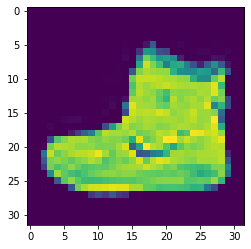

In [ ]:
"""
JYI - data exploration
"""
print(type(xdata))
print(xdata.shape)
print(np.max(xdata))
plt.figure()
plt.imshow(xdata[0,])

print(type(y_train))
print(y_train.shape)
print(y_train[0])

- tf.sequeeze, https://www.tensorflow.org/api_docs/python/tf/squeeze
- tf.where, https://www.tensorflow.org/api_docs/python/tf/where


In [ ]:
# Initialize geometry object used in CT imaging

geometry = set_geometry_info(volume_size=32)


geometry.detector_origin: [-399.5]
geometry.ray_vectors.shape: (180, 2)
geometry.sinogram_shape: [180 800]
geometry.volume_origin: [-15.5 -15.5]
geometry.source_detector_distance: None
geometry.source_isocenter_distance: None


(-1.1, 1.1, -1.1, 1.1)

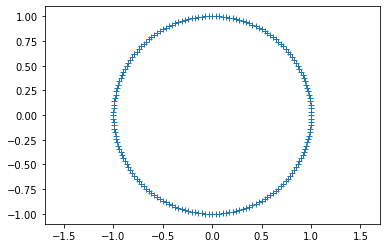

In [ ]:
"""
JYI - geometry object exploration - 2
"""

# print(f'geometry.detector_origin: {geometry.detector_origin}')
# print(f'geometry.ray_vectors.shape: {geometry.ray_vectors.shape}')
# print(f'geometry.sinogram_shape: {geometry.sinogram_shape}')
# print(f'geometry.volume_origin: {geometry.volume_origin}')
# print(f'geometry.source_detector_distance: {geometry.source_detector_distance}')
# print(f'geometry.source_isocenter_distance: {geometry.source_isocenter_distance}')

# plt.figure()
# plt.plot(geometry.ray_vectors[:,0],geometry.ray_vectors[:,1],'+')
# plt.axis('equal')

In [ ]:
"""
JYI - geometry object exploration - 1
- center of the image as origin of coordinate system --> image origin will be -H/2, -W/2
- 
"""

#geometry_JYI = set_geometry_info()
# print("geometry: {}\n".format(geometry_JYI))

# sinogram_shape_JYI = geometry_JYI.sinogram_shape
# print("sinogram_shape: {}\n".format(geometry_JYI.sinogram_shape))

# volume_origin_broadcast_JYI = np.broadcast_to(geometry_JYI.volume_origin, [5, *np.shape(geometry_JYI.volume_origin)])
# print("volume_origin_broadcast_JYI: {}\n".format(volume_origin_broadcast_JYI))

# volume_origin_JYI = geometry_JYI.volume_origin
# print("volume_origin_JYI: {}\n".format(volume_origin_JYI))

# detector_origin_JYI = geometry_JYI.detector_origin
# print("detector_origin_JYI: {}\n".format(detector_origin_JYI))

# ray_vectors_broadcast_JYI = np.broadcast_to(geometry_JYI.ray_vectors, [5, *np.shape(geometry_JYI.ray_vectors)])
# print("ray_vectors_broadcast_JYI: {}\n".format(ray_vectors_broadcast_JYI.shape))

# detector_shape_JYI = geometry_JYI.detector_shape
# print("detector_shape_JYI: {}\n".format(detector_shape_JYI))

# print(*np.shape(geometry_JYI.volume_origin))
# print(*np.shape(np.array([[1,2],[3,4]])))



In [ ]:
# Initialize and compile model

model = simple_model(geometry, mask_slopes=[5.0, None])

import tensorflow_addons as tfa
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
#               loss=tf.keras.losses.MeanSquaredError(), 
#               metrics=['mse'])


# model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
#               loss=tf.keras.losses.MeanSquaredError(), 
#               metrics=['mse'])

model.compile(optimizer=tfa.optimizers.SGDW(
                        weight_decay=0,
                        momentum=0.5,
                        learning_rate=1e-3), 
              loss=tf.keras.losses.MeanSquaredError(),                        # use MSE or MAE.
              # loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mse', 'mae']
              )



In [ ]:
"""
JYI - model exploration
- 
"""

print("model.summary: {}\n".format(model.summary))

model.summary: <bound method Model.summary of <__main__.simple_model object at 0x7fb5b26b2190>>



In [ ]:
history = model.fit(x=xdata, y=xdata,
                    batch_size=100,
                    initial_epoch=0,
                    epochs=5,
                    validation_split=0.2,
                    verbose=1) # originally 20 epcohs

Epoch 1/5
48/48 [==============================] - 6s 135ms/step - loss: 2.7037 - mse: 0.1746 - mae: 0.3509 - val_loss: 2.6730 - val_mse: 0.1497 - val_mae: 0.3616
Epoch 2/5
48/48 [==============================] - 5s 98ms/step - loss: 2.6267 - mse: 0.1090 - mae: 0.2725 - val_loss: 2.6509 - val_mse: 0.1390 - val_mae: 0.3487
Epoch 3/5
48/48 [==============================] - 5s 99ms/step - loss: 2.5955 - mse: 0.0892 - mae: 0.2465 - val_loss: 2.6336 - val_mse: 0.1331 - val_mae: 0.3392
Epoch 4/5
48/48 [==============================] - 5s 97ms/step - loss: 2.5733 - mse: 0.0784 - mae: 0.2312 - val_loss: 2.6164 - val_mse: 0.1272 - val_mae: 0.3292
Epoch 5/5
48/48 [==============================] - 5s 97ms/step - loss: 2.5542 - mse: 0.0707 - mae: 0.2194 - val_loss: 2.5988 - val_mse: 0.1211 - val_mae: 0.3187


In [ ]:
# After training, locate the selected angles 
tf.where( tf.sigmoid(5.0 * model.trainable_variables[0] ) > 0.5 ).shape

<tf.Tensor: shape=(72, 1), dtype=int64, numpy=
array([[  4],
       [  5],
       [  6],
       [  8],
       [  9],
       [ 10],
       [ 13],
       [ 18],
       [ 20],
       [ 24],
       [ 27],
       [ 30],
       [ 32],
       [ 33],
       [ 34],
       [ 40],
       [ 42],
       [ 46],
       [ 47],
       [ 51],
       [ 53],
       [ 56],
       [ 60],
       [ 61],
       [ 69],
       [ 71],
       [ 75],
       [ 76],
       [ 78],
       [ 80],
       [ 81],
       [ 85],
       [ 86],
       [ 89],
       [ 96],
       [ 98],
       [ 99],
       [100],
       [103],
       [104],
       [105],
       [106],
       [107],
       [108],
       [113],
       [115],
       [116],
       [120],
       [123],
       [124],
       [125],
       [126],
       [129],
       [132],
       [135],
       [138],
       [141],
       [142],
       [149],
       [151],
       [152],
       [153],
       [154],
       [155],
       [159],
       [160],
       [164],
       [167],
 

(-0.5, 31.5, 31.5, -0.5)

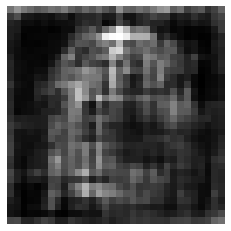

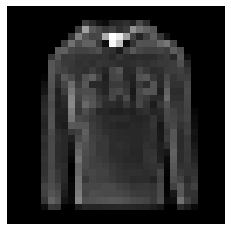

In [ ]:
image = tf.expand_dims( xdata[90,...] , axis=0)
out_image = model(image, training=False) 

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.squeeze(out_image), cmap=plt.get_cmap('gist_gray'))
plt.axis('off')

plt.figure()
plt.imshow(np.squeeze(image), cmap=plt.get_cmap('gist_gray'))
plt.axis('off')

# Fix the mask layer and train the network only.

In [ ]:
for k,_ in model._get_trainable_state().items():
    if k.name == "mask":
      k.trainable = False

In [ ]:
model.compile(optimizer=tfa.optimizers.SGDW(
                        weight_decay=0,
                        momentum=0.8,
                        learning_rate=1e-2), 
              # loss=tf.keras.losses.MeanSquaredError(), 
              loss=tf.keras.losses.MeanAbsoluteError(),
              # metrics=['mse'],
              metrics=['mae']
              )

In [ ]:

history = model.fit(x=xdata, y=xdata,
                    batch_size=200,
                    initial_epoch=0,
                    epochs=20,
                    validation_split=0.2,
                    verbose=1) # originally 200

Epoch 1/20
24/24 [==============================] - 4s 172ms/step - loss: 2.5203 - mae: 0.0426 - val_loss: 2.5378 - val_mae: 0.0600
Epoch 2/20
24/24 [==============================] - 4s 170ms/step - loss: 2.5193 - mae: 0.0415 - val_loss: 2.5279 - val_mae: 0.0502
Epoch 3/20
24/24 [==============================] - 4s 171ms/step - loss: 2.5184 - mae: 0.0407 - val_loss: 2.5259 - val_mae: 0.0482
Epoch 4/20
24/24 [==============================] - 4s 166ms/step - loss: 2.5175 - mae: 0.0398 - val_loss: 2.5197 - val_mae: 0.0420
Epoch 5/20
24/24 [==============================] - 4s 169ms/step - loss: 2.5171 - mae: 0.0393 - val_loss: 2.5196 - val_mae: 0.0418
Epoch 6/20
24/24 [==============================] - 4s 169ms/step - loss: 2.5162 - mae: 0.0385 - val_loss: 2.5171 - val_mae: 0.0394
Epoch 7/20
24/24 [==============================] - 4s 170ms/step - loss: 2.5160 - mae: 0.0382 - val_loss: 2.5150 - val_mae: 0.0372
Epoch 8/20
24/24 [==============================] - 4s 168ms/step - loss: 2.

(-0.5, 31.5, 31.5, -0.5)

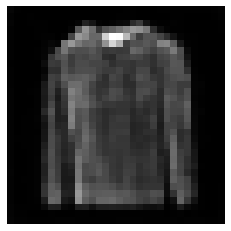

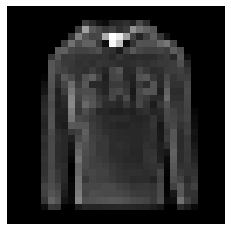

In [ ]:
image = tf.expand_dims( xdata[90,...] , axis=0)
out_image = model(image, training=False) 

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.squeeze(out_image), cmap=plt.get_cmap('gist_gray'))
plt.axis('off')

plt.figure()
plt.imshow(np.squeeze(image), cmap=plt.get_cmap('gist_gray'))
plt.axis('off')